# Import Modules

In [82]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import numpy as np


warnings.filterwarnings('ignore')

In [71]:
os.getcwd()
file_path = '/Users/talhajamal/Desktop/Code/ChallengeData24/qrt/'
os.chdir(file_path)

# Training Data

In [72]:
# Team Statistics
train_home_team_statistics_df = pd.read_csv('data/Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('data/Train_Data/train_away_team_statistics_df.csv', index_col=0)

# Player Statistics
train_home_player_statistics_df = pd.read_csv('data/Train_Data/train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('data/Train_Data/train_away_player_statistics_df.csv', index_col=0)

# Train Scores
train_scores = pd.read_csv('data/Y_train_1rknArQ.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})


# Test Data

In [73]:
# Team Statistics
test_home_team_statistics_df = pd.read_csv('data/Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('data/Test_Data/test_away_team_statistics_df.csv', index_col=0)

# Player Statistics
test_home_player_statistics_df = pd.read_csv('data/Test_Data/test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('data/Test_Data/test_away_player_statistics_df.csv', index_col=0)


test_home = test_home_team_statistics_df
test_away = test_away_team_statistics_df

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)

test_data = test_data.replace({np.inf:np.nan,-np.inf:np.nan})


# Running a LightGBM Model

In [78]:
def lgbm_cv_grid_search(X, Y):
    """
    Function to run a LGBM model with Cross Validation and Grid Search to Optimize the Parameters
    """

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.8, random_state=42)
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

    # Define parameters for LightGBM
    param_grid = {
        'boosting_type': 'gbdt',
        'max_depth': 8, 
        'learning_rate': 0.025,
        'objective': 'multiclass',
        'num_class': 2,
        'metric': 'multi_logloss',
        'num_leaves': 31  # Set a reasonable value for num_leaves
    }

    # Create LGBM datasets
    train_data = lgb.Dataset(X_train.replace({0: np.nan}), label=y_train)
    valid_data = lgb.Dataset(X_valid.replace({0: np.nan}), label=y_valid)

    # Train the model
    bst = lgb.train(param_grid, 
                    train_data, 
                    num_boost_round=10000, 
                    valid_sets=[train_data, valid_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=5)])

    # Test LGBM dataset
    predictions = bst.predict(X_test, iteration_range=(0, bst.best_iteration))
    predictions = pd.DataFrame(predictions)

    lgb.plot_importance(bst, max_num_features=25)
    fig = plt.gcf()
    fig.set_size_inches(15, 20)

    predictions[2] = 0
    predictions.columns = [0,2,1]
    predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values

    target = train_scores.loc[X_test.index].copy()

    print("The Accuracy Score on Training Set is: ", np.round(accuracy_score(predictions,target),4))

    submission_predictions = bst.predict(test_data, iteration_range=(0, bst.best_iteration))
    submission_predictions = pd.DataFrame(submission_predictions)

    submission_predictions[2] = 0
    submission_predictions.columns = [0,2,1]
    submission_predictions = (submission_predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

    submission_predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
    submission_predictions.index = test_data.index
    submission_predictions = submission_predictions.reset_index()
    submission_predictions.to_csv('data/submission/lgbm_submission.csv', index=False)

    print(submission_predictions.sum(axis=0))

    return bst

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3312
[LightGBM] [Info] Number of data points in the train set: 7873, number of used features: 280
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -0.368558
[LightGBM] [Info] Start training from score -1.176783
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.47198	valid_1's mult

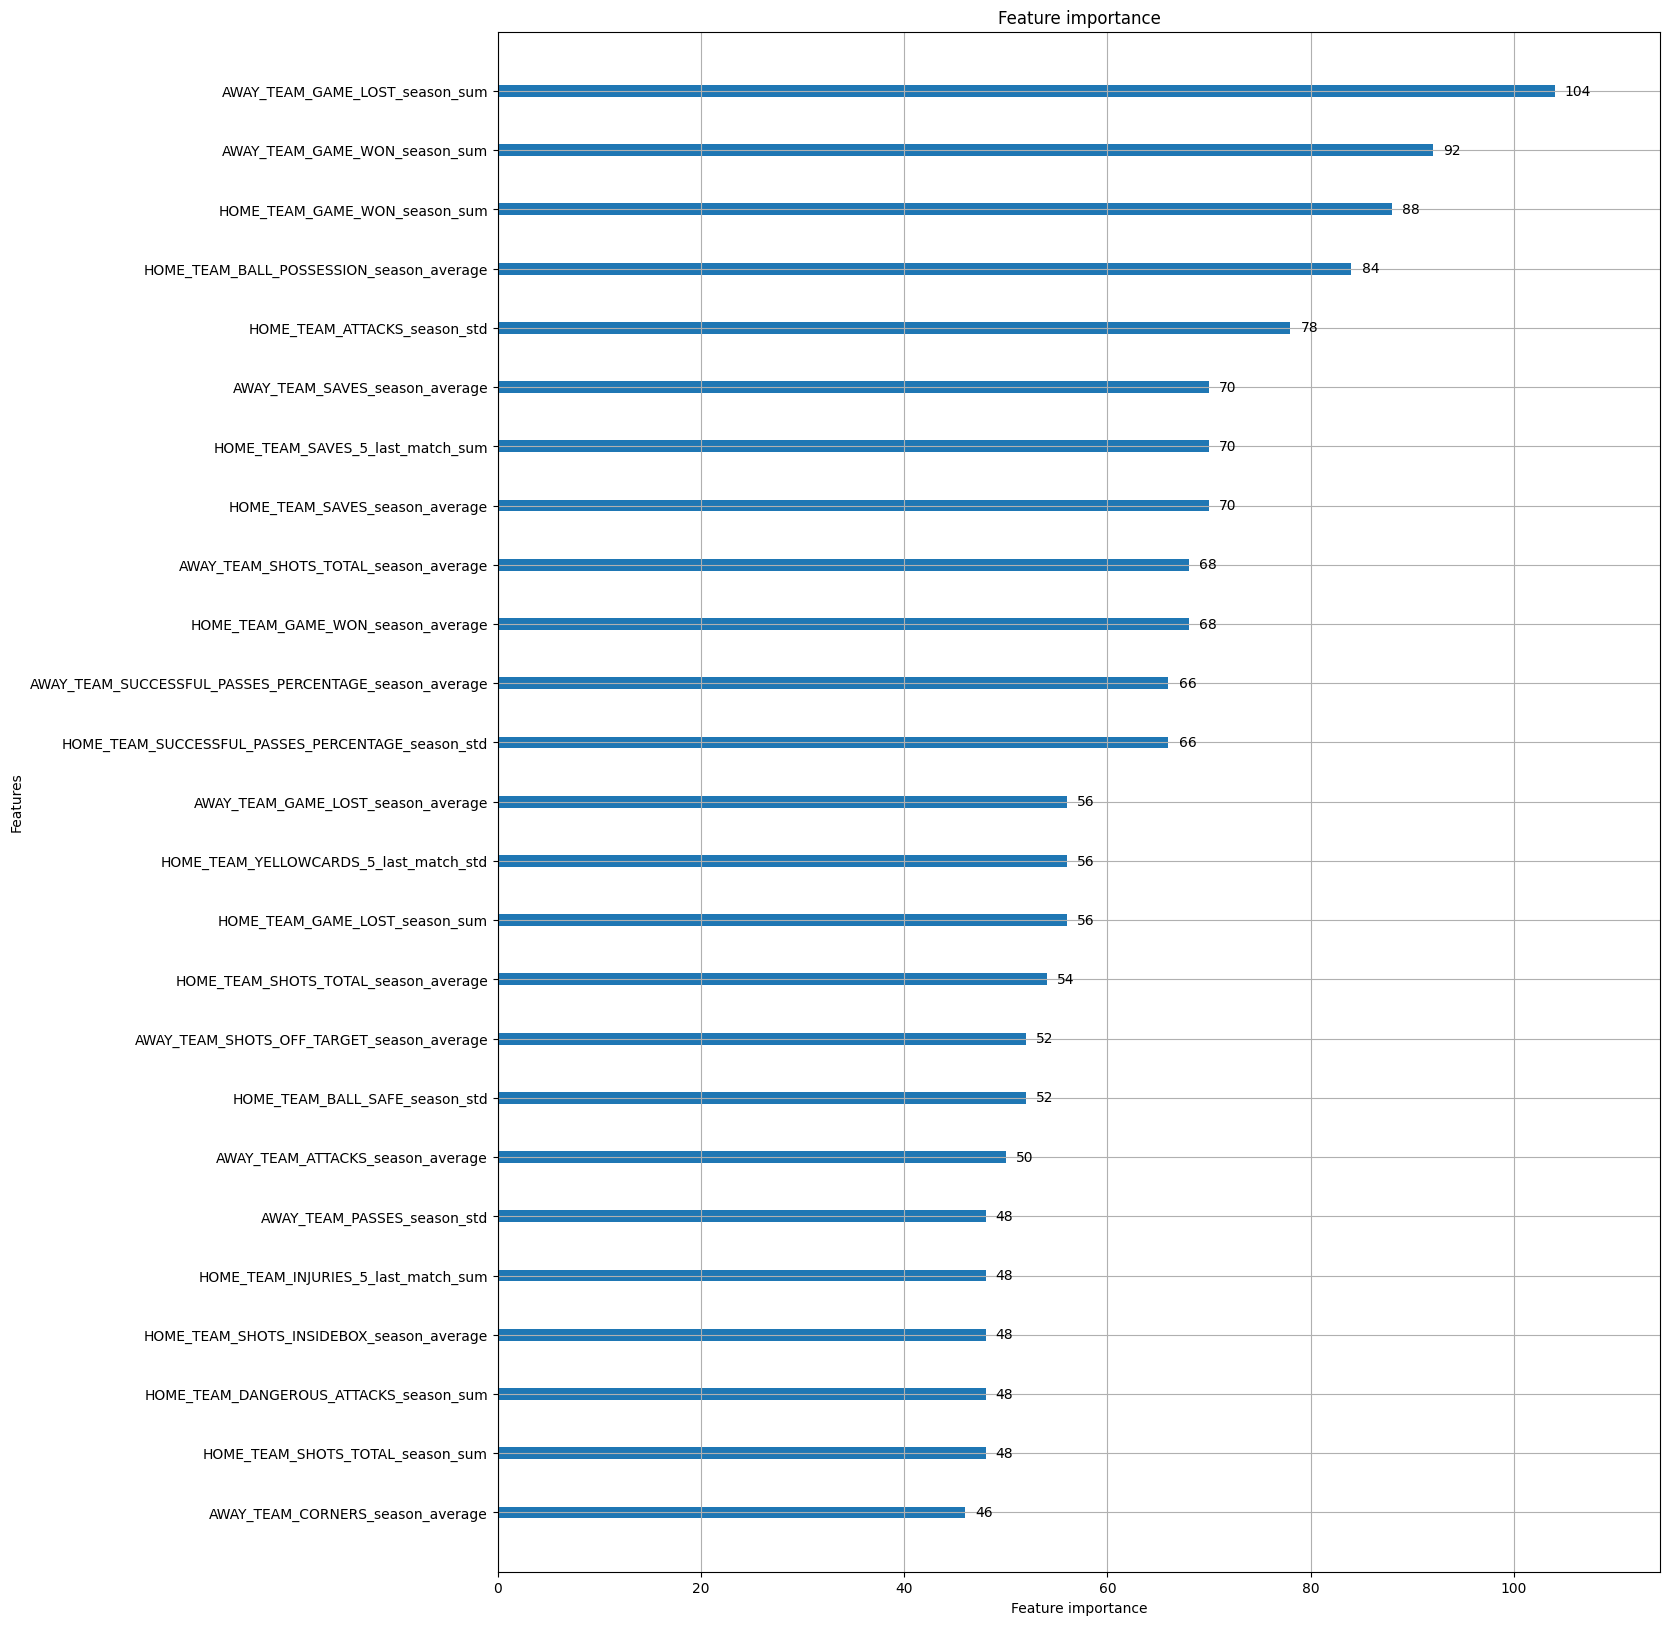

In [81]:
lgbm_cv_grid_search(train_data, train_scores['AWAY_WINS'])

# LightGBM Optimized via Grid Search

In [135]:
def get_class_from_probabilities(probabilities):
    return np.argmax(probabilities, axis=1)

def lgbm_cv_grid_search_optimized(X, Y):
    """
    Function to run a LGBM model with Cross Validation and Grid Search to Optimize the Parameters
    """

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.8, random_state=42)

    # Define a reduced parameter grid for hyperparameter tuning
    param_grid = {
        'boosting_type': ['gbdt'],
        'num_leaves': [15, 20],
        'max_depth': [5, 8],
        'learning_rate': [0.05, 0.1],
        'objective': ['multiclass'],
        'num_class': [3], # Home Win, Draw, Away Win
        'metric': ['multi_logloss'],
        'feature_fraction': [0.6, 0.8],
        'bagging_fraction': [0.6, 0.8],
        'bagging_freq': [3, 5]
    }

    # Create the base LightGBM classifier
    lgb_clf = lgb.LGBMClassifier()

    # Perform Grid Search with Cross Validation
    grid_search = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, get_class_from_probabilities(y_train))  # Convert y_train to class labels

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on test data
    y_pred_test = best_model.predict(X_test)
    y_pred_test = pd.get_dummies(y_pred_test).astype(bool).astype(int)
    y_pred_test.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test), 4)  # Convert y_test to class labels
    print("Test Accuracy:", test_accuracy)

    # Make predictions using the best model
    submission_predictions = best_model.predict(test_data)
    submission_predictions = pd.get_dummies(submission_predictions).astype(bool).astype(int)
    submission_predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
    print(submission_predictions.sum(axis=0))

    # Save predictions to CSV
    submission_predictions.to_csv('data/submission/lgbm_submission_optimized.csv', index=False)

    return best_model

In [136]:
lgbm_opt = lgbm_cv_grid_search_optimized(train_data, train_scores)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will b